## Introduction to Power Network Analysis with Pandapower
##### Xiangyue Wang, Thomas Morstyn

**Pandapower** is a popular open-sourced python package for power system modeling and optimization. Its name originates from the data analysis library, **pandas**, and the power flow solver library, **PYPOWER**. Pandapower combines the data structure of the former with solvers from the latter to:

- conduct static analysis of **three-phase distribution systems**, which are commonly found in Europe
- solve **AC and DC optimal power flow** problems
- conduct state estimation, static short-circuit simulation, and topological search.



As of Feburary, 2025, Pandapower **cannot** analyse distribution grids with unsymmetrical power lines design, such as the feeder design common in North America. It also cannot solved unbalanced power flow problems and conduct dynamic short-circuit simulation. As you will see later in this tutorial, it also has some difficulties dealing with multi-time coupled variables, but we can use it in combination with other optimization software to overcome its shortcomings.

In this notebook, we will walk you through how to use pandapower for power flow optimization.

### Installation

We recommend running this tutorial in an Anaconda environment to avoid missing dependencies.

In [3]:
pip install pandapower

Note: you may need to restart the kernel to use updated packages.


The command above could result in an error if you are starting a new virtual environment without nothing else installed. In that case, use the **requirements.txt** file I included in the repository to install pandapower together with some necessary packages such as numpy and pandas. For the plotting function to work, you also need to install igraph, which is included in the requirements.txt.

In [5]:
# pip install requirements.txt

### First Example: Power Flow Modeling Review

Recall that electric systems almost everywhere involve sinusoidally varying AC voltages and currents. In other words,
$$ V(t) = V_{max} sin(\omega t+\theta_v)$$
$$ I(t) = I_{max} sin(\omega t+\theta_i)$$
where $\theta_v, \theta_i$ are phase angles, and $\omega$ is the angular frequency (50 Hz or 100 times of direction change per second for Europe). We are interested in steady state conditions at this fixed frequency since this is where normal power system operation takes place. **Specifically, we wish to find the voltage magnitude and voltage angle across the network given a set of generators and loads.**

In DC Power Flow Modeling, we are particularly concerned with the voltage angle difference between buses. For convenience, we set all voltage angles as the difference relative to a reference bus (called the **slack bus**, normally the largest generator for transmission network), whose angle is conventionally set to zero.

For example, if you have two voltage signals:

Bus 1 voltage: $V_1=V_{max}sin⁡(ωt)$

Bus 2 voltage: $V_2=V_{max}sin⁡(ωt−10\degree)$

The voltage angle of Bus 2 is -10° relative to Bus 1, or $V_2 = V_{max}\angle -10\degree$.
Note that voltage angles aren't physical angles of objects. Instead, they're determined indirectly using Phasor Measurement Units (PMUs), which measure precise time-stamped voltage and current waveforms at buses. Just as water moves from higher to lower pressure, electric power flows from higher voltage angle (sources) to lower voltage angle (loads). 

In DC Power Flow, we assume nodes have small voltage angle differences and small voltage drops (typically true for transmission) in order to linearize the sinusoidal AC voltage. For DC power flow, the power flow from bus k to j is

$$P_{kj} = \frac{1}{x_{kj}}(\theta_k - \theta_j) = B_{kj}(\theta_k - \theta_j)$$

where $x_{kj}$ is the line reactance and $B_{kj}$ is the line suceptance, or the kj-th entry of the admittance matrix.

Recall this example from the lecture:

![example_1.png](images/example_1.png)

where **pu** stands for **per unit** to simplify the calculation. Let's try to replicate this grid in pandapower. 
### How to Make a Grid in Pandapower
First, we import pandapower as **pp** and create an empty network using **pp.create_empty_network()**.

In [7]:
import pandapower as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandapower.plotting as plot

# Create an empty network
net1 = pp.create_empty_network()
print('network created')

network created


Then, we create the buses using **create_bus**. Since the example is in a per unit system with no base unit specified, we will go ahead and assume the base voltage is 110 kV and the base apparent power is 100 MVA.

In [9]:
# Set base values for the per unit system
base_kV = 110.0 # Base voltage in kV
base_MVA = 100  # Base apparent power

#Create the buses
bus1 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 1")
bus2 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 2")
bus3 = pp.create_bus(net1, vn_kv=base_kV, name="Bus 3")

#Show the bus table
net1.bus 

,name,vn_kv,type,zone,in_service,geo
0,Bus 1,110.0,b,None,True,None
1,Bus 2,110.0,b,None,True,None
2,Bus 3,110.0,b,None,True,None


Now, let's add the generators using **create_gen**. The diagram shows two generators. The first generator is connected to the slack bus, hence we set it as the slack generator with voltage magnitude (vm_pu) of 1 per unit. 

Even when the generator is a slack, we still need to give it an initial guess for p_mw, the active power. 0 is normally fine, because pandapower will calculate the actual value during the power flow. From the problem, we also know that generator 2 has p_mw of 1 per unit and reactive power (q_mvar) of 0.5 per unit.

In [11]:
#Create the generators
pp.create_gen(net1, bus=bus1, p_mw=0, vm_pu=1.0, slack=True, name="Generator 1")
pp.create_gen(net1, bus=bus2, p_mw=base_MVA, q_mvar=0.5*base_MVA, min_p_mw=0, max_p_mw=110, name="Generator 2")

#Show the generator table
net1.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,q_mvar,min_p_mw,max_p_mw
0,Generator 1,0,0.0,1.0,NaN,NaN,NaN,1.0,True,True,0.0,None,NaN,NaN,NaN
1,Generator 2,1,100.0,1.0,NaN,NaN,NaN,1.0,False,True,0.0,None,50.0,0.0,110.0


Now, let's add the loads. We know that the load connected to bus 3 has active power of 2 per unit and reactive power of 0.5 per unit. 

In [13]:
#Create the loads
pp.create_load(net1, bus=bus3, p_mw=2*base_MVA, q_mvar=0.5*base_MVA, name="L3")

#Show the load table
net1.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,L3,2,200.0,50.0,0.0,0.0,NaN,1.0,True,wye


Lastly, let's add the lines. From the problem, we know that
$$z_{12} = 0.001 + j0.01 pu$$
$$z_{13} = 0.001 + j0.01 pu$$

meaning that each line has resistance (R) of 0.001 pu and reactance (X) of 0.01 pu. To add those lines, we need to convert per unit to Ohms by determining the base impedance:

$$Z_{base} = \frac{V^2_{base}}{S_{base}}$$

In [15]:
# Compute Base Impedance
z_base = base_kV**2 / base_MVA  # in Ohms

# Line Impedances in Ohms
r_ohm = 0.001*z_base
x_ohm = 0.01*z_base

# Create the specific line used in Example 1
example1_line = {"r_ohm_per_km": r_ohm, "x_ohm_per_km": x_ohm, "c_nf_per_km": 10, "max_i_ka": 0.4, "type": "cs"}
pp.create_std_type(net1, name="example1_line", data=example1_line, element="line")
pp.available_std_types(net1, element="line")

length_km = 1  # nominal length

pp.create_line(net1, from_bus=bus1, to_bus=bus2, length_km=length_km, std_type="example1_line", name="line12")
pp.create_line(net1, from_bus=bus1, to_bus=bus3, length_km=length_km, std_type="example1_line", name="line13")

#Show the line table
net1.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,geo
0,line12,example1_line,0,1,1.0,0.121,1.21,10.0,0.0,0.4,1.0,1,cs,True,NaN
1,line13,example1_line,0,2,1.0,0.121,1.21,10.0,0.0,0.4,1.0,1,cs,True,NaN


Now, let's have a look at the grid we created. Note that you need to pip install igraph.

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


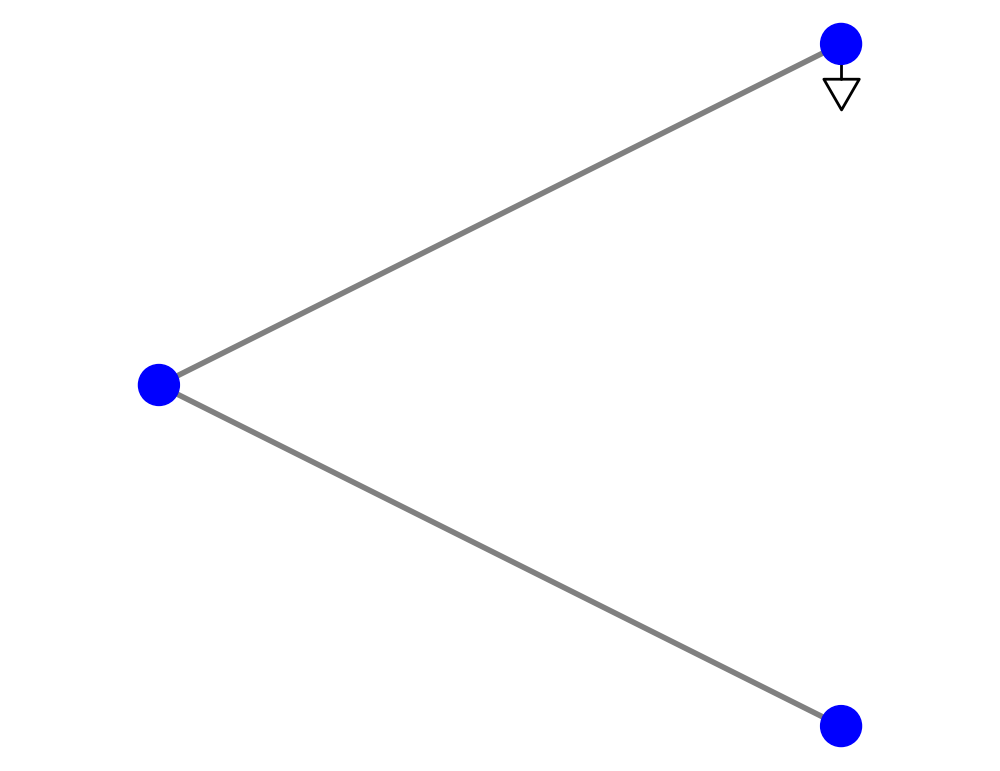

<Axes: >

In [17]:
#Show the Example 1 grid
plot.simple_plot(net1, show_plot=True, plot_loads=True, plot_sgens=True, sgen_size =3, load_size=3, line_width=4, bus_size=3)

Let's go back to the question:

![example_1.png](images/example_1.png)

Recall how we would solve this problem analytically:

$$
\begin{bmatrix}
P_1\\
P_2\\
\vdots\\
P_N
\end{bmatrix}=\textbf{B}\begin{bmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_N
\end{bmatrix}=
\begin{bmatrix}
B_{12} + B_{13} + \dots + B_{1N} & -B_{12}                 & \dots & -B_{1N}\\
-B_{21}                          & B_{21} + B_{22} + \dots + B_{2N} & \dots & -B_{2N}\\
\vdots                           & \vdots                           & \ddots & \vdots\\
-B_{N1}                          & -B_{N2}                          & \dots & B_{N1} + B_{N2} + \dots
\end{bmatrix}
\begin{bmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_N
\end{bmatrix}
$$

where $B_{ij} = \frac{1}{x_{ij}}$

Write the admittance matrix B for this problem and solve analytically.

Remember that you can remove the slack bus row and column (row 1 and column 1) from B since we set the voltage angle for slack bus as 0 degree. If you don't do it, B will not be invertible. For the final answer, add the $P_1$ and $\theta_1$ back to P and theta vectors and convert theta from radian to degrees. 

In [19]:
#Initialize
B = np.zeros(shape=(3,3))
theta = np.zeros(shape=(3,1))
P = np.zeros(shape=(3,1))

#Enter your answer here


#Check Answer
print ('P is correct') if np.array_equal(P.flatten(),([1,1,-2])) else print ('P is wrong.')
print ('theta is correct') if np.allclose(theta.flatten(), ([0,0.5729578,-1.14591559])) else print ('Theta is wrong.')


P is wrong.
Theta is wrong.


Now, we will solve the DC power flow using pandapower's DC power flow solver.

In [21]:
#DC Power Flow
pp.rundcpp(net1)
print(net1.res_bus)


   vm_pu  va_degree   p_mw  q_mvar
0    1.0   0.000000 -100.0     NaN
1    1.0   0.572958 -100.0     NaN
2    1.0  -1.145916  200.0     NaN


We can also solve the same grid using the Balanced AC Power flow function.

In [23]:
# Run balanced AC power flow
pp.runpp(net1)
print(net1.res_bus)

      vm_pu  va_degree        p_mw     q_mvar
0  1.000000   0.000000 -100.532105 -64.754756
1  1.000000   0.578405 -100.000000   9.509458
2  0.992758  -1.125501  200.000000  50.000000


### Second Example: Optimal Power Flow
Let's look at another example from the lecture. 
![example_2.png](images/example_2.png)

This time we are trying to optimize the power flow based on the cost of generation for each generator. Again, the problem didn't tell us much about the generators. To make things interesting, let's assume each of them has maximum power of 150 MW.

Try creating an empty network and adding the generators and load yourself. 

Note: you can use **pp.create_poly_cost** to add cost of generation for each generator.


In [25]:
#Try to create the grid youself



Check your grid here.

In [27]:
# Create an empty network
net2 = pp.create_empty_network()

# Set base values for the per unit system
base_kV = 110 # Base voltage in kV
base_MVA = 100 # Base apparent power

#Create the buses
b1 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 1")
b2 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 2")
b3 = pp.create_bus(net2, vn_kv=base_kV, name="Bus 3")

#Create the generators 
gen1 = pp.create_gen(net2, bus=b1,  p_mw=0, min_p_mw=0, max_p_mw=150, vm_pu=1.0, slack=True, name="Generator 1")
gen2 = pp.create_gen(net2, bus=b2, p_mw=0, min_p_mw=0, max_p_mw=150, name="Generator 2")
gen3 = pp.create_gen(net2, bus=b3, p_mw=0, min_p_mw=0, max_p_mw=150, name="Generator 3")

# Add generator costs
pp.create_poly_cost(net2, element=gen1, et='gen', cp1_eur_per_mw=20)
pp.create_poly_cost(net2, element=gen2, et='gen', cp1_eur_per_mw=30)
pp.create_poly_cost(net2, element=gen3, et='gen', cp1_eur_per_mw=100)

#Create the loads
pp.create_load(net2, bus=b2, p_mw=3*base_MVA, q_mvar=0.5*base_MVA, name="L2")

#Show buses
net2.bus


,name,vn_kv,type,zone,in_service,geo
0,Bus 1,110.0,b,None,True,None
1,Bus 2,110.0,b,None,True,None
2,Bus 3,110.0,b,None,True,None


Now, we need to add the lines with the specific powerflow limits. To add the limits, we need to convert the power limit into current limit. Recall that apparent power (S) in a three-phase system is given by
$$S = \sqrt{3}VI$$
$$I = \sqrt{3}VS$$
We will create a function **mw_to_ka** to do so.

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


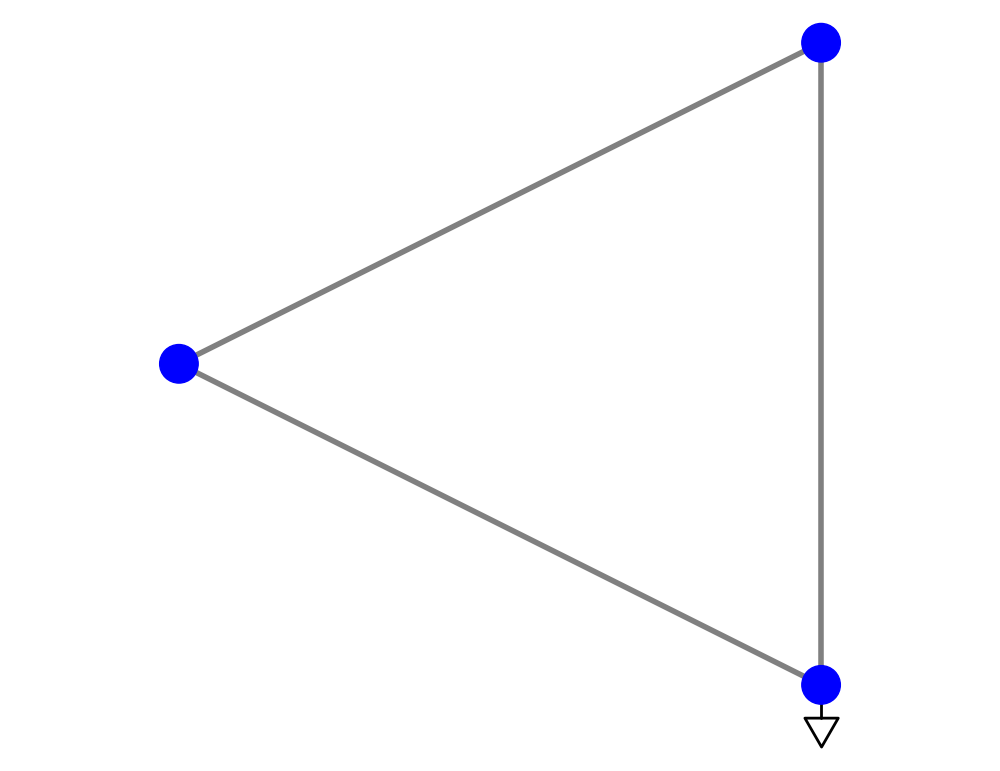

<Axes: >

In [29]:
# Compute Base Impedance
z_base = base_kV**2 / base_MVA  # in Ohms

# Line Impedances in Ohms
r_ohm = 0 # Since we don't have the info, let's assume we have negligible resistance
x_ohm = 0.5*z_base

length_km = 1  # nominal length

#Convert line flow limits from MW to kA (approx)
def mw_to_ka(p_mw, v_kv=base_kV):
    return p_mw / (v_kv * (3)**0.5)

# Add lines with limits
pp.create_line_from_parameters(net2, b1, b2, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(200), name="line12")

pp.create_line_from_parameters(net2, b1, b3, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(200), name="line13")

pp.create_line_from_parameters(net2, b2, b3, length_km=1,
    r_ohm_per_km=r_ohm, x_ohm_per_km=x_ohm, c_nf_per_km=0,
    max_i_ka=mw_to_ka(50), name="line23")

#Show the Example 2 grid
plot.simple_plot(net2, show_plot=True, plot_loads=True, plot_sgens=True, sgen_size =3, load_size=3, line_width=4, bus_size=3)

In [30]:
# Run DC Optimal Power Flow
pp.rundcopp(net2)
print("DC OPF")
print(net2.res_bus)
print("Optimal Cost is", net2.res_cost)


DC OPF
   vm_pu  va_degree          p_mw  q_mvar      lam_p  lam_q
0    1.0   0.000000 -1.500000e+02     NaN  39.168005    0.0
1    1.0 -28.647890  1.500000e+02     NaN  39.168005    0.0
2    1.0 -14.323945 -7.702557e-07     NaN  39.168005    0.0
Optimal Cost is 7500.000026262323


In [31]:
# Run AC Optimal Power Flow
pp.runopp(net2)
print("AC OPF")
print(net2.res_bus)
print("Optimal Cost is", net2.res_cost)

AC OPF
      vm_pu     va_degree        p_mw     q_mvar      lam_p         lam_q
0  0.989713 -4.659016e-18 -149.999998 -26.684012  75.109011  6.255358e-21
1  1.020575 -2.947453e+01  150.000002 -45.181712  75.109011  1.577475e-20
2  0.989712 -1.496867e+01   -0.000004  -6.977596  75.109011  2.527559e-21
Optimal Cost is 7500.000286796514


#### Solve Using PICOS

For comparison, we can also try to solve the problem using **PICOS**, a python convex optimization package.

![example_2.png](images/example_2.png)

Our decision variables are the generator outputs, $P_{g1}, P_{g2}$, and $P_{g3}$ as well as the voltage angles $\theta_2, \theta_3$.


In [33]:
pip install picos

Note: you may need to restart the kernel to use updated packages.


In [34]:
import picos as pic

# Initialize the optimization problem.
prob = pic.Problem()

# Add decision variables: (name, size)
Pg1    = pic.RealVariable("Pg1") 
Pg2    = pic.RealVariable("Pg2")
Pg3    = pic.RealVariable("Pg3")
theta2 = pic.RealVariable("theta2")
theta3 = pic.RealVariable("theta3")
print('Variables created.')

Variables created.


The objective function that we wish to minimize is the cost function:
$$C = 20P_{g1}+30P_{g2}+100P_{g3}$$

In [36]:
# Set objective function
prob.set_objective("min", 20*Pg1 + 30*Pg2 + 100*Pg3)
print('objective function created')

objective function created


Lastly, the constraints are the power flow limit:
$$P_{kj} = \frac{1}{x_{kj}}(\theta_k - \theta_j)$$

which we have to convert to constraints on $P_{g1}, P_{g2}, P_{g3}$. Looking at the graph, we can notice that for bus 1:
$$P_{g1} = P_{12} + P_{13}$$
where 
$$P_{12} = 2(\theta_1 - \theta_2) = -2\theta_2$$
and 
$$P_{13} = 2(\theta_1 - \theta_3) = -2\theta_3$$

Hence
$$P_{g1} = -2\theta_2 - 2\theta_3$$

For bus 2, we don't expect the generator to transmit power through the lines since it is right next to the load.

For bus 3, since it is the most expensive, we can assume that it is used sparingly. In other words,
$$P_{g3} = P_{31} + P_{32} = P_{32} = 2(\theta_3 - \theta_2)$$

Lastly, we have to meet the demand.
$$P_{g1} + P_{g2} + P{g3} = 300$$


We will aslo add the line limits and generator limits (which, again, we assume since the problem doesn't provide the details).

In [38]:
# Power flow constraints:
prob.add_constraint(Pg1 + 2*theta2 + 2*theta3 == 0)  # Bus 1
prob.add_constraint(Pg3 - 2*theta3 + 2*theta2 == 0)  # Bus 2
prob.add_constraint(Pg1 + Pg2 + Pg3 == 300)  # Meet Demand

# Line limits
prob.add_constraint(theta2 >= -100)  # line 12
prob.add_constraint(theta2 <= 100)  # line 12
prob.add_constraint(theta3 >= -100)  # line 13
prob.add_constraint(theta3 <= 100)  # line 13
prob.add_constraint((theta2 - theta3)>= -25)  # line 23
prob.add_constraint((theta2 - theta3)<= 25)  # line 23

# Add generation bounds: 0 <= Pg_i <= 150
prob.add_constraint(Pg1 >= 0)
prob.add_constraint(Pg1 <= 150)
prob.add_constraint(Pg2 >= 0)
prob.add_constraint(Pg2 <= 150)
prob.add_constraint(Pg3 >= 0)
prob.add_constraint(Pg3 <= 150)

#Show constraints
prob.constraints

mappingproxy({116184275: <1×1 Affine Constraint: Pg1 + 2·theta2 + 2·theta3 = 0>,
              116184276: <1×1 Affine Constraint: Pg3 - 2·theta3 + 2·theta2 = 0>,
              116184277: <1×1 Affine Constraint: Pg1 + Pg2 + Pg3 = 300>,
              116184278: <1×1 Affine Constraint: theta2 ≥ -100>,
              116184279: <1×1 Affine Constraint: theta2 ≤ 100>,
              116184280: <1×1 Affine Constraint: theta3 ≥ -100>,
              116184281: <1×1 Affine Constraint: theta3 ≤ 100>,
              116184282: <1×1 Affine Constraint: theta2 - theta3 ≥ -25>,
              116184283: <1×1 Affine Constraint: theta2 - theta3 ≤ 25>,
              116184284: <1×1 Affine Constraint: Pg1 ≥ 0>,
              116184285: <1×1 Affine Constraint: Pg1 ≤ 150>,
              116184286: <1×1 Affine Constraint: Pg2 ≥ 0>,
              116184287: <1×1 Affine Constraint: Pg2 ≤ 150>,
              116184288: <1×1 Affine Constraint: Pg3 ≥ 0>,
              116184289: <1×1 Affine Constraint: Pg3 ≤ 150>})

In [39]:
# Solve the optimization problem.
solution = prob.solve(verbosity=True)

            PICOS 2.6.0            
Problem type: Linear Program.
Searching a solution strategy.
Solution strategy:
  1. ExtraOptions
  2. CVXOPTSolver
Applying ExtraOptions.
Building a CVXOPT problem instance.
Starting solution search.
-----------------------------------
 Python Convex Optimization Solver 
    via internal CONELP solver     
-----------------------------------
     pcost       dcost       gap    pres   dres   k/t
 0:  1.3819e+04 -4.7340e+03  2e+04  2e-01  3e-16  1e+00
 1:  6.0854e+03 -1.5191e+04  3e+04  2e-01  2e-15  5e+02
 2:  7.4767e+03  6.5839e+03  1e+03  1e-02  7e-15  7e+01
 3:  7.5007e+03  7.4904e+03  1e+01  1e-04  2e-15  8e-01
 4:  7.5000e+03  7.4999e+03  1e-01  1e-06  6e-16  8e-03
 5:  7.5000e+03  7.5000e+03  1e-03  1e-08  7e-16  8e-05
 6:  7.5000e+03  7.5000e+03  1e-05  1e-10  1e-15  8e-07
Optimal solution found.
------------[ CVXOPT ]-------------
Solver claims optimal solution for feasible problem.
Applying the solution.
Applied solution is primal feasible.


In [40]:
# Print the results.
print("Pg1 =", Pg1)
print("Pg2 =", Pg2)
print("Pg3 =", Pg3)
print("theta2 =", theta2)
print("theta3 =", theta3)
print("\nCost = ", prob.value)

Pg1 = 149.99999999815253
Pg2 = 149.99999999275937
Pg3 = 9.088089391503269e-09
theta2 = -37.50000000181015
theta3 = -37.4999999972661

Cost =  7500.000000654641


Does the cost from PICOS match that of pandapower?

### Third Example: Great Britain Network

For our third example, let's look at a commonly used network available in pandapower.  The Great Britain (GB) Network represents the UK electricity transmission network. It consists of 2224 nodes, 3207 branches and 394 generators. We will import it from **pandapower.networks**, which contains a set of other useful grids. You can find out about them [here.](https://pandapower.readthedocs.io/en/v2.0.0/networks/power_system_test_cases.html#case-gb-network)

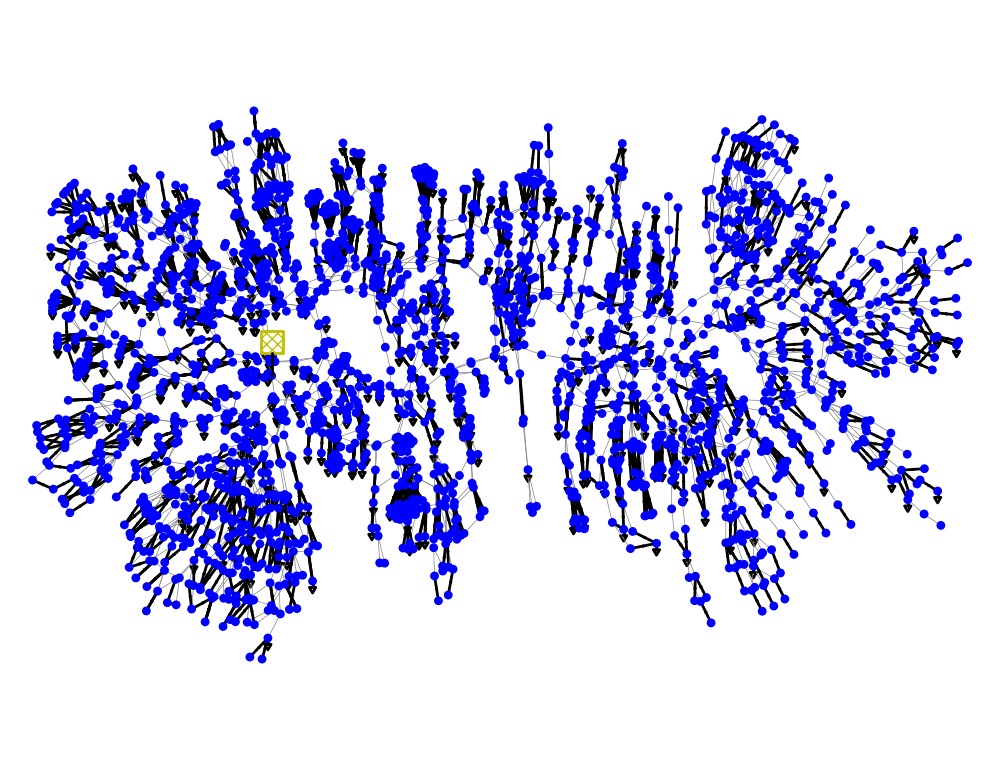

<Axes: >

In [43]:
import pandapower.networks as pn
net3 = pn.GBnetwork()
plot.simple_plot(net3, show_plot=True, plot_loads=True, load_size=0.5, trafo_size=0.02, line_width=0.5, bus_size=0.5)

Solve both DC and AC Power flow on this grid. Observe the results describe which generators are used the most.

In [45]:
#DC Power Flow
pp.rundcpp(net3)
print("DC OPF")
print(net3.res_bus)

DC OPF
      vm_pu  va_degree      p_mw  q_mvar
0      1.00  -0.078287    0.0000     NaN
1      1.05   4.585871 -303.7966     NaN
2      1.05   4.629992 -304.3822     NaN
3      1.05   4.580016 -303.9515     NaN
4      1.00   2.404447    0.0000     NaN
...     ...        ...       ...     ...
2219   1.00  68.787756   33.1300     NaN
2220   1.00  63.632587    0.0000     NaN
2221   1.00  63.633114    0.0000     NaN
2222   1.00  61.042266    9.7700     NaN
2223   1.00  54.279564    0.0000     NaN

[2224 rows x 4 columns]


In [46]:
#AC Power Flow
pp.runpp(net3)
print("DC OPF")
print(net3.res_bus)

DC OPF
         vm_pu  va_degree      p_mw    q_mvar
0     1.049121  -1.492784    0.0000  0.000000
1     1.050000   2.744737 -303.7966 -0.899733
2     1.050000   2.782975 -304.3822 -8.167780
3     1.050000   2.738866 -303.9515 -2.298052
4     1.040346   0.293261    0.0000  0.000000
...        ...        ...       ...       ...
2219  1.057775  55.507208   33.1300 -0.089511
2220  1.000752  50.890542    0.0000  0.000000
2221  1.000762  50.890952    0.0000  0.000000
2222  1.038314  48.494137    9.7700  1.980000
2223  1.092362  42.246951    0.0000  0.000000

[2224 rows x 4 columns]


Try to explore the outputs of the generators. Do you observe any geographical trends?



### Multi-period Optimization with Energy Storage
To conclude, let's take everything we've learned so far and attempt to operate a small but more realistic grid for a day.

Since OPF is a problem that needs to be solved continuously due to varying demand and supply (for variable sources such as wind and solar), the real-world scenario asks us to solve a time series of OPF problems. The OPF problem is solved for each specified time step (say, 15 min) with separate decision variables for each time interval. Since we are operating the grid for a day using 15-min intervals, we need to solve the OPF 96 times. 

Furthermore, let's add battery storage to the grid. The battery storage variable will be coupled with every time step throughout the day. Our objective function will then needs to include the battery storage degradation cost, and the constraints will need to include energy storage constraints.

Assuming linear storage degradation cost, $\sum_{t=1}^T c^{deg}(P_t^{ch} + P_t^{dis})$, the objective function becomes:

$$\sum_{t=1}^T\sum_{i=1}^Nc_{it}^gP_{it}^g+c_i^{deg}(P_{it}^{ch}+P_{it}^{dis})$$

where 

$P_t^{ch}$ is the charging power

$P_t^{dis}$ is the discharging power

$c^{deg}$ is the degradation cost

The objective function is subjected to the following constraints:

**Bus Power Balance Constraints**

$$B\theta_t=P_t^G+P_t^{dis}-P_t^{ch}-P_t^D, \space \forall \tau \in \{1,...,T \}$$

**Line Flow Limits**

$$-P_{ij}^{max} \le \frac{1}{x_{ij}}(\theta_{it}-\theta_{jt})\le P_{ij}^{max},  \space \forall (i,j) \in L, \tau \in \{1,...,T \}$$

**Generator Limits**

$$P_{i}^{gmin} \le P_{it}^g \le P_{ij}^{gmax},  \space \forall i \in \{1,...,N \}, \space \forall \tau \in \{1,...,T\}$$

We add the folowing constraints for battery storage:

$$E_{min}\le E_0+\sum_{t=0}^{\tau}(\eta^{ch}P_t^{ch}-\frac{1}{\eta^{dis}}P_t^{dis})\le E_{max}, \space \forall \tau \in \{1,...,T \}$$

$$E_0+\sum_{t=0}^{\tau}(\eta^{ch}P_t^{ch}-\frac{1}{\eta^{dis}}P_t^{dis})= E_{T}$$

$$0 \le P_t^{ch}\le P_{max}^{ch}, \space \forall \tau \in \{1,...,T \}$$

$$0 \le P_t^{ch}\le P_{max}^{dis}, \space \forall \tau \in \{1,...,T \}$$

where 

$E_0$ is the initial energy

$E_T$ is the required final energy

$\eta^{ch}$ is the charging efficiency

$\eta^{dis}$ is the discharging efficiency



#### Create the grid
The pre-set networks in pandapower don't have battery storage or renewable energy generators, so we will build a small one ourselves. Let's use the power grid from example 1, but this time, we will set generator 1 as a solar farm with outputs controlled largely by weather instead of us. We will create a variable named pv_curtail just to limit input from solar farm when we don't have capacity to store all of it. Generator 2 will be a wind farm with a similar curtailment variable. We will have a gas generator as a back up, and we will connect a battery. Since solar and wind farms are considered stationary generators in pandapower due to their largely uncontrollable outputs, we will use **create_sgen** instead of **create_gen**. We will also connnect an external grid to bus 1 as the slack bus.


No or insufficient geodata available --> Creating artificial coordinates. This may take some time


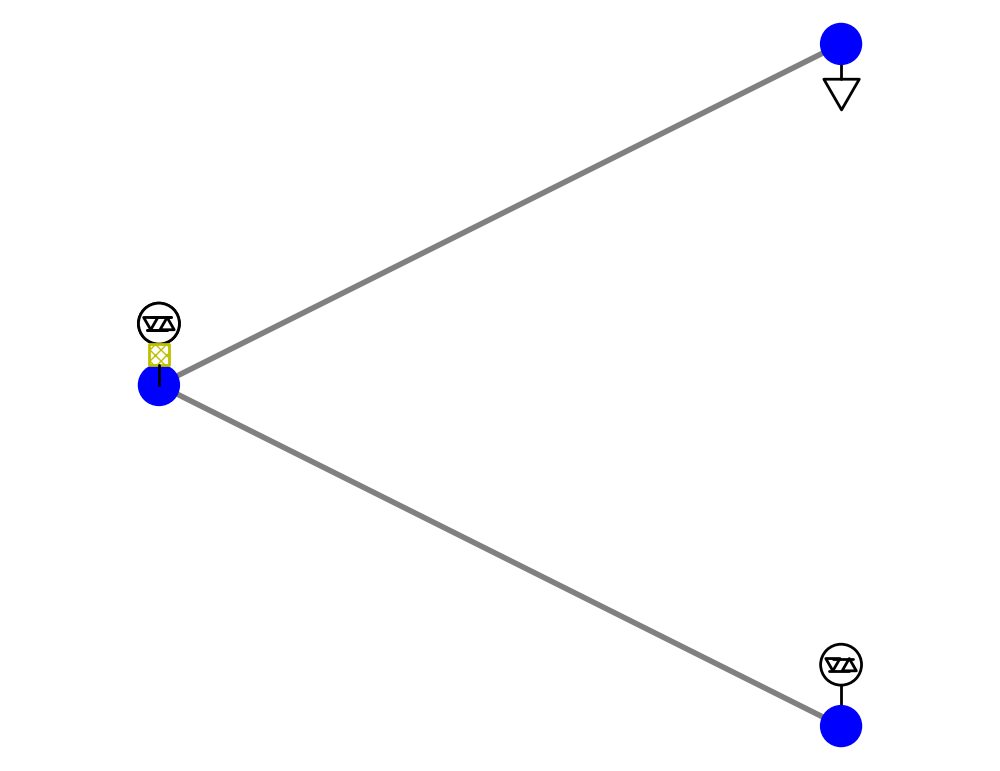

<Axes: >

In [49]:
# Create an empty network
net4 = pp.create_empty_network()

# Set base values for the per unit system
base_kV = 110.0 # Base voltage in kV
base_MVA = 100  # Base aparrent power

#Create the buses
bus1 = pp.create_bus(net4, vn_kv=base_kV, name="Bus 1")
bus2 = pp.create_bus(net4, vn_kv=base_kV, name="Bus 2")
bus3 = pp.create_bus(net4, vn_kv=base_kV, name="Bus 3")

#Create External grid (as the slack bus)
e=pp.create_ext_grid(net4, bus1, min_p_mw=-200, max_p_mw=200)

#Create the generators
sgen1 = pp.create_sgen(net4, bus=bus1, p_mw=0, q_mvar=0, min_p_mw=0, max_p_mw=110, controllable=False, name="Solar")
sgen2 = pp.create_sgen(net4, bus=bus1, p_mw=0, q_mvar=0, min_p_mw=0, max_p_mw=110, controllable=False, name="Wind")
sgen3 = pp.create_sgen(net4, bus=bus2, p_mw=0, q_mvar=0.5*base_MVA, min_p_mw=0, max_p_mw=110, controllable=True, name="Gas Generator")

# Add generator costs
pp.create_poly_cost(net4, element=sgen3, et='sgen', cp1_eur_per_mw=30)

# Create the load
pp.create_load(net4, bus=bus3, p_mw=2*base_MVA, q_mvar=0.5*base_MVA, name="Load")

# Add storage to bus 3. We assume it starts out with no charge and can store up to 1 of base power.
storage_idx = pp.create_storage(net4, bus=bus3, p_mw=0, max_e_mwh=0.5*base_MVA, soc_percent=0, min_p_mw=-0.5*base_MVA, max_p_mw=0.5*base_MVA, controllable=True)

# Line setup
z_base = base_kV**2 / base_MVA  # in Ohms
r_ohm = 0.001*z_base
x_ohm = 0.01*z_base
length_km = 1  # nominal length

# Create the specific line used in Example 4
example4_line = {"r_ohm_per_km": r_ohm, "x_ohm_per_km": x_ohm, "c_nf_per_km": 10, "max_i_ka": 0.4, "type": "cs"}
pp.create_std_type(net4, name="example4_line", data=example4_line, element="line")
pp.create_line(net4, from_bus=bus1, to_bus=bus2, length_km=length_km, std_type="example4_line", name="line12")
pp.create_line(net4, from_bus=bus1, to_bus=bus3, length_km=length_km, std_type="example4_line", name="line13")

#Show the Example 4 grid
plot.simple_plot(net4, show_plot=True, plot_loads=True, plot_sgens=True, sgen_size =3, load_size=3, line_width=4, bus_size=3)

#### Import and inspect time series
Let's have a look at the data we will use for the demand and the solar power of the day.



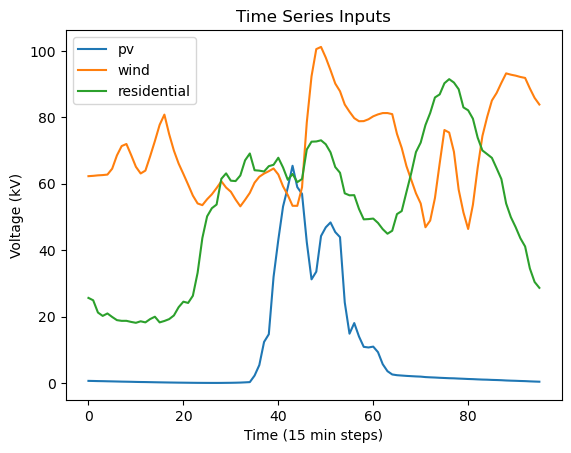

In [51]:
df = pd.read_json("data/time_series_15min.json")
df.loc[:, ['pv','wind','residential']].plot()
plt.title("Time Series Inputs")
plt.xlabel("Time (15 min steps)")
plt.ylabel("Voltage (kV)")
plt.show()

What did you notice?


#### Create objective functions, add constraints, and optimize.
We will use **PICOS** again since pandapower's **runpp** cannot incorporate a battery variable that is coupled with multiple time intervals.

In [92]:
# Setup time variables
T = 96  # 96 steps for 24 hours (15 min each)
time_steps = np.arange(T)

# Extract admittance matrix for OPF (We first need to run an OPF once to generate Ybus)
pp.runpp(net4, calculate_voltage_angles=True)
Ybus_full = net4._ppc["internal"]["Ybus"].todense()
Ybus = np.real(Ybus_full) #We only want real-valued admittance

# Generator and load mappings
gen_buses = list(net4.sgen.bus.values)
load_buses = list(net4.load.bus.values)
ext_grid_buses = list(net4.ext_grid.bus.values)
storage_bus = net4.storage.bus.at[storage_idx]

# Generator costs
gen_costs = list(net4.poly_cost.cp1_eur_per_mw.values)

# Variables
var_shapes = {
    "Pg": len(gen_buses),
    "Pch": 1,
    "Pdis": 1,
    "E": 1,
    "Theta": len(net4.bus),
    "pv_curtail": 1,
    "wind_curtail": 1
}

# Initialize variables
vars = {name: [] for name in var_shapes}

# Create variables
for t in range(T):
    for name, size in var_shapes.items():
        vars[name].append(pic.RealVariable(f"{name}_{t}", size))

Pg = [pic.RealVariable(f"Pg_{t}", len(gen_buses)) for t in range(T)] #Conrollable generators' power
Pch = [pic.RealVariable(f"Pch_{t}", 1) for t in range(T)] #Battery charging powers
Pdis = [pic.RealVariable(f"Pdis_{t}", 1) for t in range(T)] #Battery discharging powers
E = [pic.RealVariable(f"E_{t}", 1) for t in range(T)] #Battery state of charge
Theta = [pic.RealVariable(f"Theta_{t}", len(net4.bus)) for t in range(T)] #Voltage angles
pv_curtail = [pic.RealVariable(f"pv_curtail_{t}", 1) for t in range(T)] #additional variable to control solar output
wind_curtail = [pic.RealVariable(f"wind_curtail_{t}", 1) for t in range(T)]  #additional variable to control wind output

# Battery Parameters
eta_ch = 0.95 #charging efficiency
eta_dis = 0.95 #discharging efficiency
c_deg = 10 #battery degradation cost in pound per MW for charging or discharging
max_e_mwh = net4.storage.max_e_mwh.at[storage_idx]
Pch_max = net4.storage.max_p_mw.at[storage_idx]
Pdis_max = net4.storage.max_p_mw.at[storage_idx]

# Setup optimization model
prob = pic.Problem()

# Objective function components
gen_cost_vector = pic.Constant("gen_cost_vector", np.array(gen_costs)) #we need to convert the cost list to a PICOs vector for matrix multiplication
gen_cost_term = pic.sum([gen_cost_vector | vars["Pg"][t] for t in range(T)]) #| in PICOS is the same as @, matrix multiplication
storage_deg_cost = pic.sum([c_deg * (vars["Pch"][t][0] + vars["Pdis"][t][0]) for t in range(T)])

# Objective function
prob.set_objective("min", gen_cost_term + storage_deg_cost)

# Constraints
for t in range(T):
    # Power balance constraint
    load = df['residential'].values[t]
    pv_gen = df['pv'].values[t]
    wind_gen = df['wind'].values[t]
    injections = pic.sum(vars["Pg"][t])  + (pv_gen - vars["pv_curtail"][t]) + (wind_gen - vars["wind_curtail"][t]) + vars["Pdis"][t] - vars["Pch"][t]
    prob.add_constraint(injections == load)

    #Line flow constraints
    flow_limit = 100 * base_MVA / base_kV  # Set line limit appropriately

    for line_idx in net4.line.index:
        # Get from and to buses for the line
        from_bus = net4.line.at[line_idx, "from_bus"]
        to_bus = net4.line.at[line_idx, "to_bus"]
    
        # Line flow is 1/x_ij * (theta_from - theta_to)
        line_flow = 1/(x_ohm*length_km) * (vars["Theta"][t][from_bus] - vars["Theta"][t][to_bus])
    
        # Add line flow constraints
        prob.add_constraint(line_flow >= -flow_limit)
        prob.add_constraint(line_flow <= flow_limit)

    # Generator limits
    prob.add_constraint(0 <= vars["Pg"][t])
    prob.add_constraint(vars["Pg"][t] <= 110)
    prob.add_constraint(0 <= (pv_gen - vars["pv_curtail"][t]))
    prob.add_constraint(0 <= (wind_gen - vars["wind_curtail"][t]))
    
    # Storage charge/discharge limits
    prob.add_constraint(0 <= vars["Pch"][t])
    prob.add_constraint(vars["Pch"][t] <= Pch_max)
    prob.add_constraint(0 <= vars["Pdis"][t])
    prob.add_constraint(vars["Pdis"][t] <= Pdis_max)

    #Wind and solar curtailment cannot be negative
    prob.add_constraint(0 <= vars["pv_curtail"][t])
    prob.add_constraint(0 <= vars["wind_curtail"][t])
        
    # Storage energy dynamics
    if t == 0:
        prob.add_constraint(vars["E"][t] == 0)
        continue
    else:
        #We multiply the 0.25 (15 min/1hr = 0.25) to transform the unit to MWh. 
        prob.add_constraint(vars["E"][t] == vars["E"][t-1] + eta_ch * vars["Pch"][t] * 0.25 - (1/eta_dis) * vars["Pdis"][t] * 0.25)
    prob.add_constraint(0 <= vars["E"][t])
    prob.add_constraint(vars["E"][t] <= max_e_mwh)

# Solve 
prob.solve(verbosity=True)

print("Optimization completed.")

            PICOS 2.6.0            
Problem type: Linear Program.
Searching a solution strategy.
Solution strategy:
  1. ExtraOptions
  2. CVXOPTSolver
Applying ExtraOptions.
Building a CVXOPT problem instance.
Starting solution search.
-----------------------------------
 Python Convex Optimization Solver 
    via internal CONELP solver     
-----------------------------------
     pcost       dcost       gap    pres   dres   k/t
 0:  2.7168e+05 -8.2931e+05  2e+06  6e-01  3e-10  1e+00
 1:  3.7064e+02 -3.3484e+05  5e+05  2e-01  1e-09  9e+01
 2:  3.9286e+03 -8.0235e+04  1e+05  4e-02  4e-10  3e+01
 3:  6.6263e+03 -1.9146e+04  4e+04  1e-02  2e-10  1e+01
 4:  7.5823e+03 -1.1597e+04  3e+04  1e-02  2e-10  1e+01
 5:  8.3531e+03  4.9043e+03  5e+03  2e-03  6e-11  2e+00
 6:  8.5245e+03  8.0625e+03  6e+02  2e-04  2e-11  3e-01
 7:  8.5494e+03  8.5125e+03  5e+01  2e-05  7e-12  2e-02
 8:  8.5515e+03  8.5511e+03  7e-01  3e-07  2e-12  3e-04
 9:  8.5516e+03  8.5516e+03  7e-03  2e-09  4e-13  3e-06
10:  

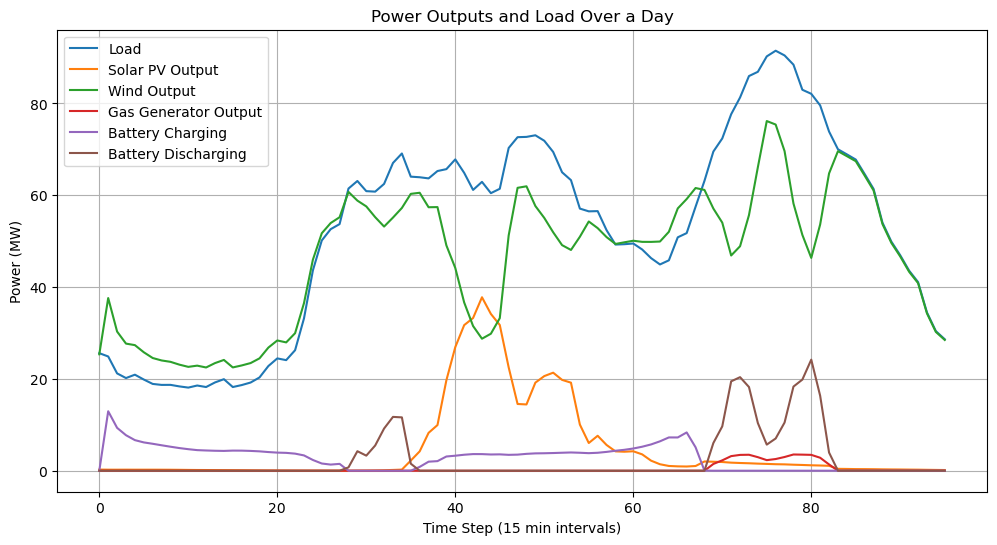

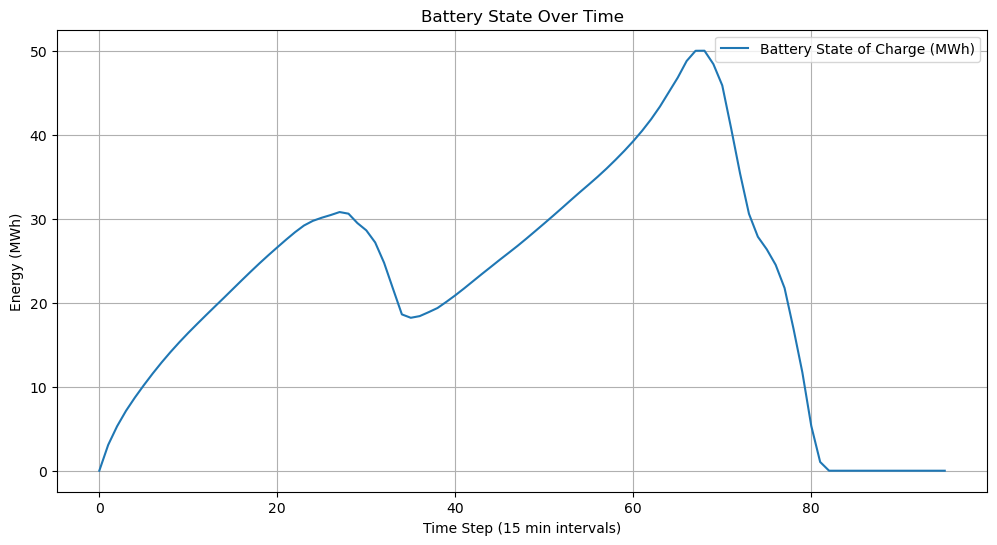

In [93]:
# Plot results

# Create storage for values
Pg_values = []
Pch_values = []
Pdis_values = []
E_values = []
pv_curtail_values = []
wind_curtail_values = []

# Load all values in one loop
for t in range(T):
    Pg_values.append(vars["Pg"][t].value)
    Pch_values.append(vars["Pch"][t].value)
    Pdis_values.append(vars["Pdis"][t].value)
    E_values.append(vars["E"][t].value)
    pv_curtail_values.append(vars["pv_curtail"][t].value)
    wind_curtail_values.append(vars["wind_curtail"][t].value)

# Convert lists to arrays
Pg_values = np.array(Pg_values).reshape(T, -1)
Pch_values = np.array(Pch_values)
Pdis_values = np.array(Pdis_values)
E_values = np.array(E_values)
pv_curtail_values = np.array(pv_curtail_values)
wind_curtail_values = np.array(wind_curtail_values)


# Actual renewable generations
pv_actual = df['pv'].values - pv_curtail_values
wind_actual = df['wind'].values - wind_curtail_values
load = df['residential'].values


plt.figure(figsize=(12,6))
plt.plot(time_steps, load, label="Load")
plt.plot(time_steps, pv_actual, label="Solar PV Output")
plt.plot(time_steps, wind_actual, label="Wind Output")
plt.plot(time_steps, Pg_values[:,1], label="Gas Generator Output")
plt.plot(time_steps, Pch_values, label="Battery Charging")
plt.plot(time_steps, Pdis_values, label="Battery Discharging")
plt.xlabel("Time Step (15 min intervals)")
plt.ylabel("Power (MW)")
plt.title("Power Outputs and Load Over a Day")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(time_steps, E_values, label="Battery State of Charge (MWh)")
plt.xlabel("Time Step (15 min intervals)")
plt.ylabel("Energy (MWh)")
plt.title("Battery State Over Time")
plt.legend()
plt.grid(True)
plt.show()

What did you observe?
